In [5]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json
import datetime

%pip install keras-tuner --upgrade
import keras_tuner
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Dense, Bidirectional
from tensorflow.keras.optimizers import Adam
from keras.callbacks import EarlyStopping
from tensorflow.keras.metrics import RootMeanSquaredError, MeanAbsoluteError
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from tensorflow.keras.optimizers.schedules import ExponentialDecay

from common_functions import *


def plot_loss(history):
    plt.plot(history.history['loss'], label='train')
    plt.plot(history.history['val_loss'], label='val')
    plt.title("Loss")
    plt.legend()
    plt.show()


def create_dataset(data, look_back=1):
    X, Y = [], []
    for i in range(len(data)-look_back-1):
        X.append(data[i:(i+look_back), 0])
        Y.append(data[(i+look_back), 0])
    return np.array(X), np.array(Y)


def build_model(hp, train_shape, look_back):
    model = Sequential()
    #  if hp is passed then tune hyperparameters
    if hp:
        model.add(LSTM(units=hp.Int('lstm_units_1', min_value=32, max_value=366, step=32), return_sequences=False, input_shape=(look_back, 1)))
        model.add(Dense(1))
        hp_learning_rate = hp.Float('learning_rate', min_value=1e-4, max_value=1e-2, sampling='log')
        model.compile(loss="mean_squared_error", optimizer=Adam(learning_rate=hp_learning_rate), metrics=[RootMeanSquaredError(), MeanAbsoluteError()])
    else:
        # return_sequences = True for stacked LSTM, where last LSTM layer must have return_sequences = False!
        model.add(LSTM(units=100, return_sequences=False, input_shape=(look_back, 1)))
        model.add(Dense(1))
        model.compile(loss="mean_squared_error", optimizer=Adam(learning_rate=0.001), metrics=[RootMeanSquaredError(), MeanAbsoluteError()])

    return model

def split_data(df, offset, train_size, test_size):
    train_data = df.loc[df.index.min() + pd.DateOffset(days=offset) : df.index.min() + pd.DateOffset(days=offset) + pd.DateOffset(months=train_size)]

    # If there is no number_of_test_values left in the df to the end, then train and test should be none
    if train_data.index.max() + pd.DateOffset(days=test_size) > df.index.max():
        return None, None, None, None, None, None

    test_data = df.loc[train_data.index.max() + pd.DateOffset(days=1) : train_data.index.max() + pd.DateOffset(days=test_size)]

    start_date, slice_date, end_date = train_data.index.min(), train_data.index.max(), test_data.index.max()

    scaler = MinMaxScaler(feature_range=(0,1))
    train_data = scaler.fit_transform(train_data)
    test_data = scaler.transform(test_data)

    return train_data, test_data, scaler, start_date, slice_date, end_date

def train_LSTM_model(train_data, look_back, batch_size, epochs, tune_hyperparameters):
    # Prepare input and output for LSTM model
    x_train, y_train = create_dataset(train_data, look_back)

    # LSTM expects inputs to be shaped as (batch_size, timesteps, channels) or (num_samples, timesteps, features)
    x_train = np.reshape(x_train, (x_train.shape[0], look_back, 1))

    # Splitting the last val_size of data for validation
    val_size = int(0.1 * len(x_train))
    x_train, y_train = x_train[:-val_size], y_train[:-val_size]
    x_val, y_val = x_train[-val_size:], y_train[-val_size:]

    early_stop = EarlyStopping(monitor='val_loss', patience=2, verbose=1)

    if tune_hyperparameters:
        # Training the model
        tuner = keras_tuner.Hyperband(
                            # must be wrapped in lambda because build_model() takes more than hp as argument
                            hypermodel=lambda hp: build_model(hp, x_train.shape[0], look_back),
                            objective=[keras_tuner.Objective("val_loss", "min")],
                            max_epochs=10,
                            overwrite=True,
                            project_name='LSTM_hyperparameter_tuning'
                            )
        tuner.search(x_train, y_train, epochs=20, validation_data=(x_val, y_val), callbacks=[early_stop])
        best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]
        print("\nBest hyperparameters: \n")
        print(best_hps.values)

        model = tuner.hypermodel.build(best_hps)
    else:
        model = build_model(hp=None, train_shape=x_train.shape[0], look_back=look_back)

    history = model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, verbose=0,
                        validation_data=(x_val, y_val), callbacks=[early_stop])


    return model, history

def test_LSTM_model(model, train_data, test_data, look_back, scaler):
    # Testing the model using sequential predictions
    # making test set: x_test[0] = x_train[-5:]; x_test[1] = x_train[-4:],x_test[0]; x_test[2] = x_train[-3:],x_test[0],x_test[1] and so on
    x_test = train_data[-look_back:]
    y_test = test_data
    testPredict = []

    for i in range(0, len(test_data)):
        x_test, y_test = np.array(x_test), np.array(y_test)
        x_test = np.reshape(x_test, (1, look_back, 1))
        y_pred = model.predict(x_test, verbose=0)
        # append y_pred value to testPredict
        testPredict.append(y_pred[0][0])
        # push the predictions to the end of the test set so it pushes out first value
        x_test = np.append(x_test, y_pred[0][0])
        # x_test = np.append(x_test, y_test[i][0])
        x_test = x_test[1:]

    testPredict = np.reshape(testPredict, (-1,1))
    testPredict = scaler.inverse_transform(testPredict)
    y_test = scaler.inverse_transform(y_test)

    mae = mean_absolute_error(y_test, testPredict)
    rmse = np.sqrt(mean_squared_error(y_test, testPredict))
    r2 = r2_score(y_test, testPredict)
    smape = calculate_smape(y_test, testPredict)

    print("RMSE:", rmse)
    print("MAE:", mae)
    print("R2 Score:", r2)
    print("SMAPE:", smape)

    return rmse, mae, r2, smape, testPredict, y_test


Running experiment for dataset_aqi_hourly.csv with label AQI:



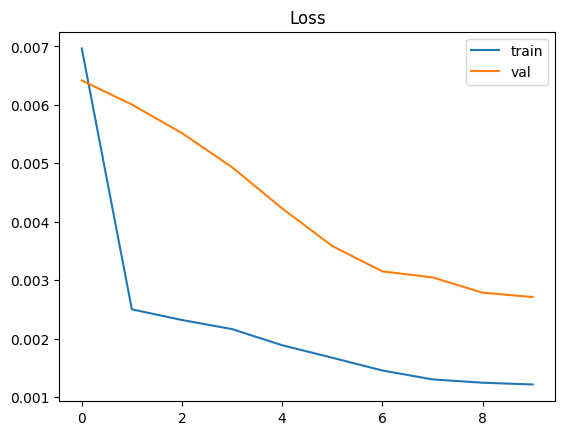

RMSE: 22.513096282397008
MAE: 17.080297756836988
R2 Score: -0.06885012910378663
SMAPE: 32.03987895161654
Finished iteration offset=1057 days train_size=12 months test_size=28 days



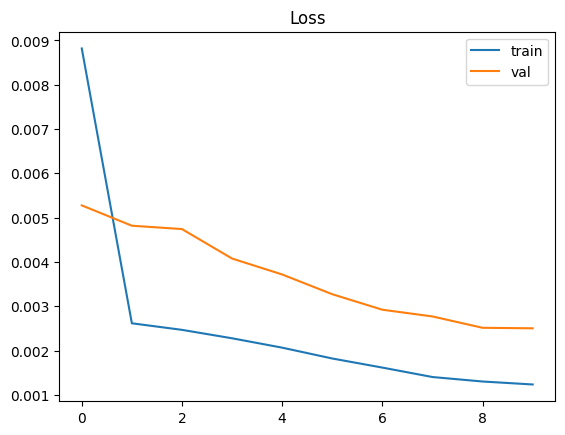

RMSE: 19.035261458390583
MAE: 14.867432459580343
R2 Score: -0.10379844619376999
SMAPE: 29.043016974054552
Finished iteration offset=1064 days train_size=12 months test_size=28 days



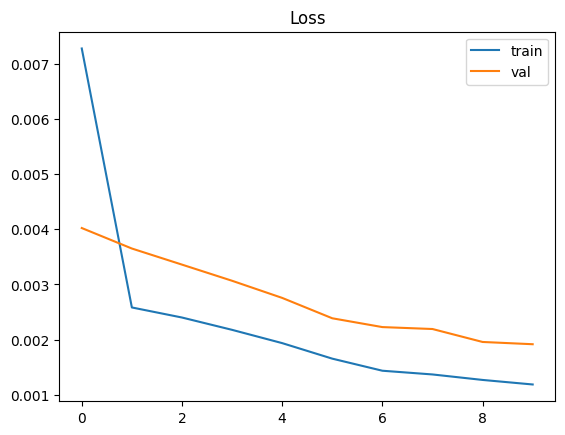

RMSE: 29.28396384496753
MAE: 25.866096792412478
R2 Score: -2.7719348552752874
SMAPE: 41.62289742896337
Finished iteration offset=1071 days train_size=12 months test_size=28 days



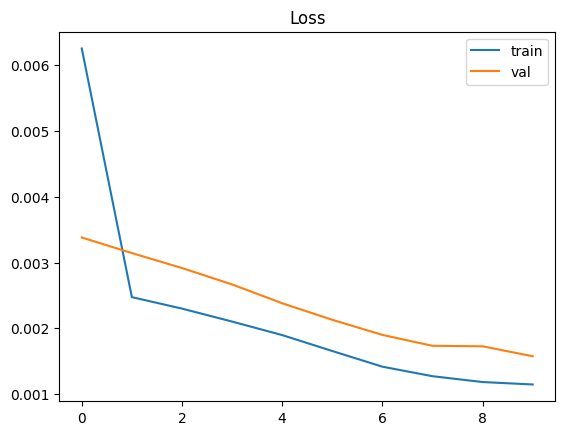

RMSE: 17.280196089716085
MAE: 14.301425047053408
R2 Score: -1.4992300305619843
SMAPE: 24.070200359379893
Finished iteration offset=1078 days train_size=12 months test_size=28 days



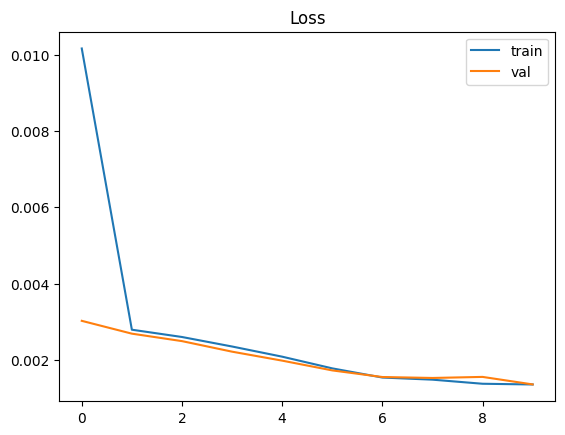

RMSE: 38.42107803660205
MAE: 35.87190815098596
R2 Score: -8.790159168543923
SMAPE: 50.08208276108157
Finished iteration offset=1085 days train_size=12 months test_size=28 days

Epoch 9: early stopping


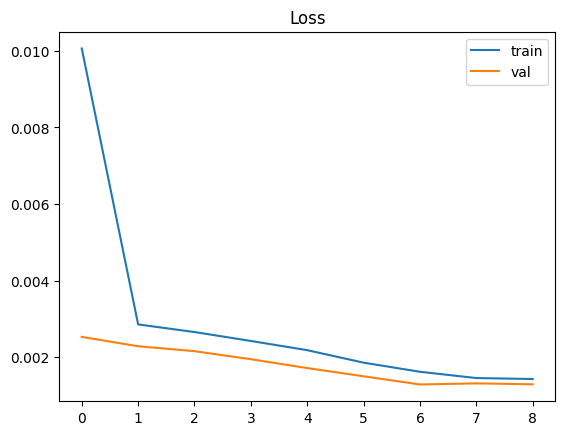

RMSE: 199.2364683210139
MAE: 193.1345846335663
R2 Score: -232.6273731939026
SMAPE: 122.82894611964807
Finished iteration offset=1092 days train_size=12 months test_size=28 days



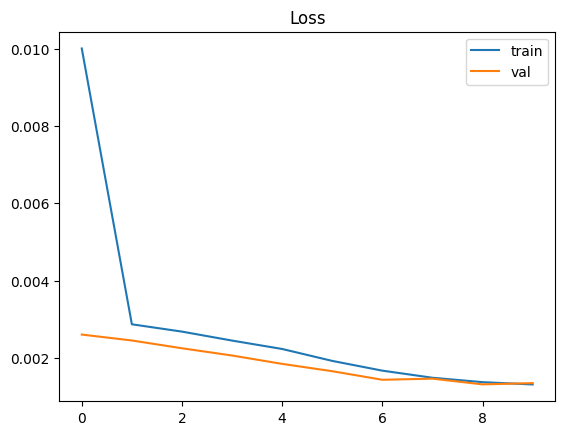

RMSE: 269.9457107658306
MAE: 262.92494605569277
R2 Score: -325.84405060440105
SMAPE: 137.37178717127614
Finished iteration offset=1099 days train_size=12 months test_size=28 days



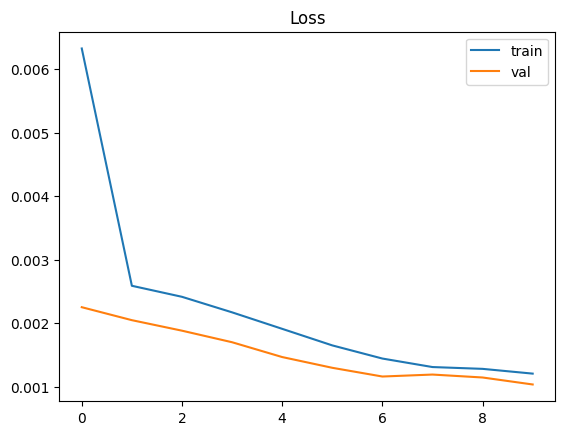

RMSE: 72.38508972552773
MAE: 69.58713032769558
R2 Score: -19.888921501525154
SMAPE: 77.75318390075809
Finished iteration offset=1106 days train_size=12 months test_size=28 days



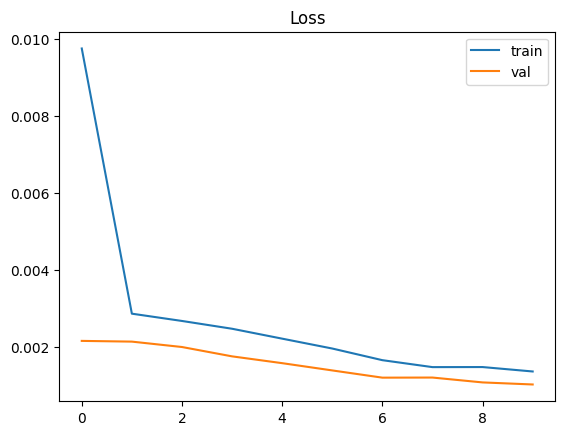

RMSE: 24.307183841034714
MAE: 20.436244493366324
R2 Score: -1.3887224282281925
SMAPE: 32.84319579159951
Finished iteration offset=1113 days train_size=12 months test_size=28 days

Epoch 8: early stopping


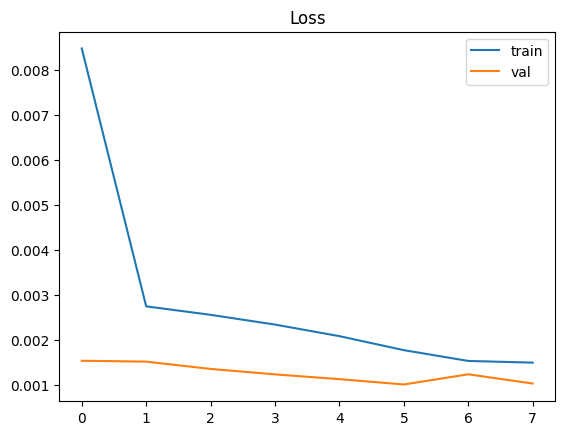

RMSE: 145.59534152838071
MAE: 142.52534669325578
R2 Score: -85.1031365974072
SMAPE: 108.67629939251049
Finished iteration offset=1120 days train_size=12 months test_size=28 days



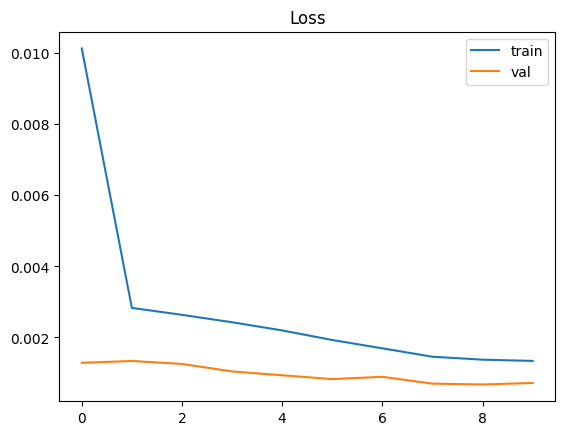

RMSE: 94.25998973778506
MAE: 90.62994390829047
R2 Score: -25.60458253448479
SMAPE: 90.97262182733863
Finished iteration offset=1127 days train_size=12 months test_size=28 days



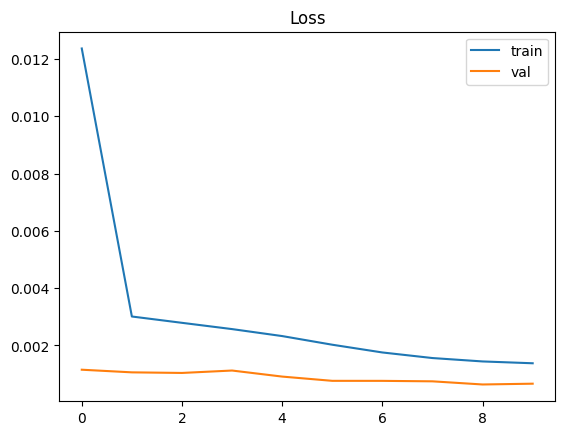

RMSE: 146.1133009879704
MAE: 140.19719464822725
R2 Score: -56.825193488731294
SMAPE: 111.76620477194098
Finished iteration offset=1134 days train_size=12 months test_size=28 days

Epoch 10: early stopping


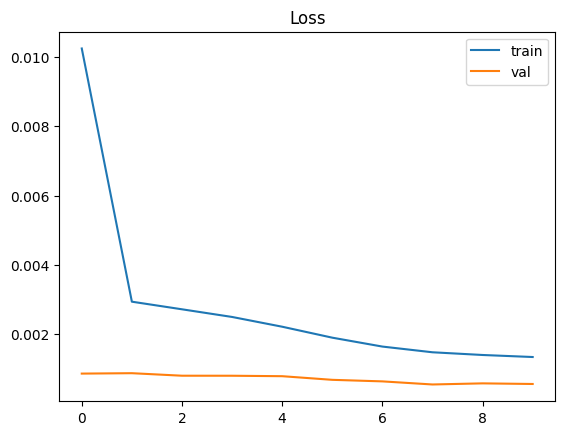

RMSE: 239.51242778872574
MAE: 227.87175509920118
R2 Score: -161.41983940336502
SMAPE: 130.05146565148527
Finished iteration offset=1141 days train_size=12 months test_size=28 days



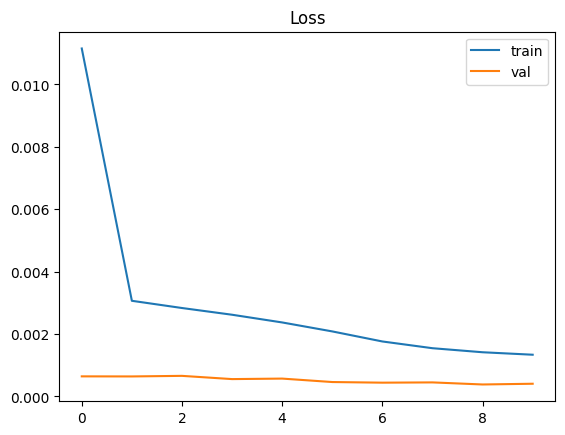

RMSE: 208.6574831812176
MAE: 200.3963548722944
R2 Score: -114.87813558554251
SMAPE: 129.32340152030076
Finished iteration offset=1148 days train_size=12 months test_size=28 days



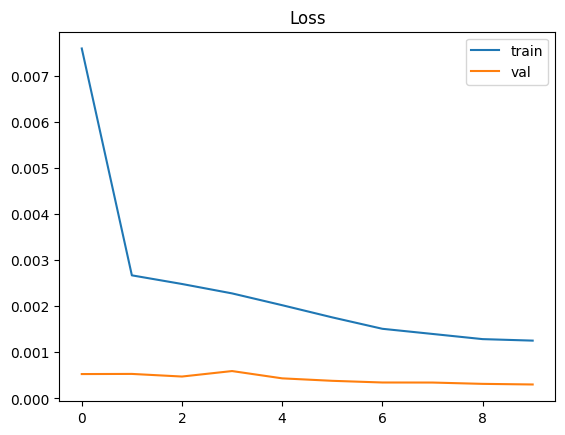

RMSE: 19.24756471176637
MAE: 15.038786548757148
R2 Score: -0.43044018626505887
SMAPE: 24.846869026752834
Finished iteration offset=1155 days train_size=12 months test_size=28 days



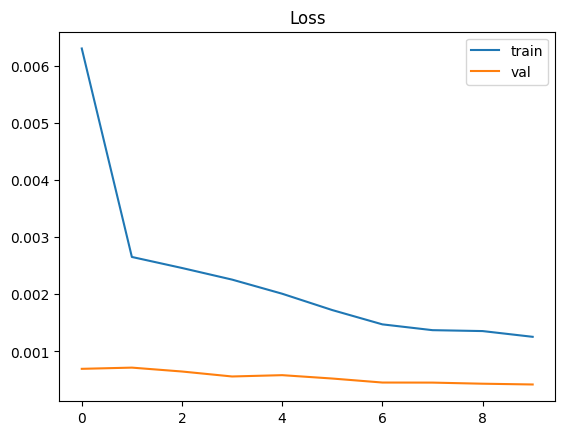

RMSE: 16.618139904305043
MAE: 13.118170101067449
R2 Score: -0.30497930452211386
SMAPE: 21.85863551768063
Finished iteration offset=1162 days train_size=12 months test_size=28 days



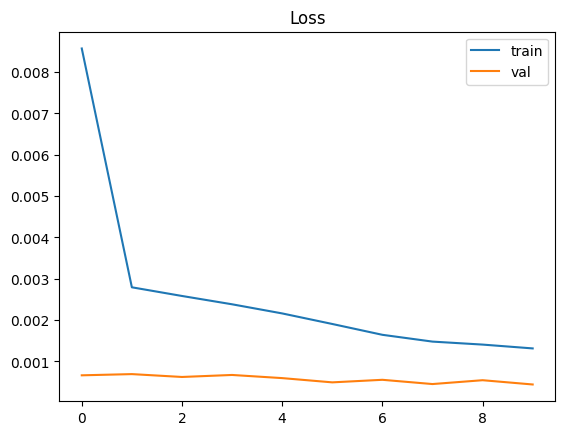

RMSE: 26.279619241201317
MAE: 22.620075216133294
R2 Score: -1.5124890453464213
SMAPE: 36.98583276913833
Finished iteration offset=1169 days train_size=12 months test_size=28 days

Epoch 9: early stopping


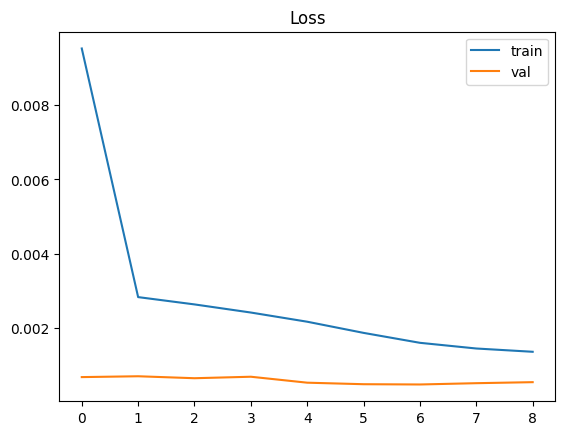

RMSE: 117.94312650313415
MAE: 114.93346228404154
R2 Score: -67.73258638248386
SMAPE: 102.12931792040084
Finished iteration offset=1176 days train_size=12 months test_size=28 days



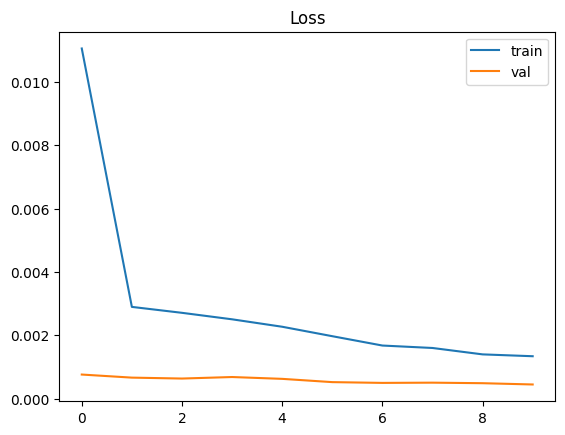

RMSE: 25.16930012319815
MAE: 20.90298559392509
R2 Score: -1.5187530933971205
SMAPE: 35.313474975433955
Finished iteration offset=1183 days train_size=12 months test_size=28 days



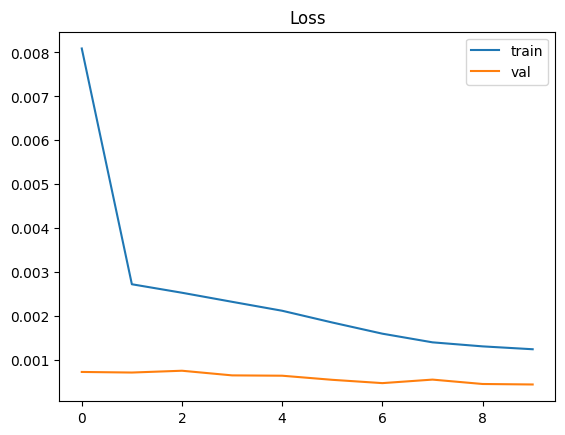

RMSE: 24.207945544527025
MAE: 20.154152279793674
R2 Score: -1.2050459203811377
SMAPE: 36.280434748605806
Finished iteration offset=1190 days train_size=12 months test_size=28 days

Epoch 3: early stopping


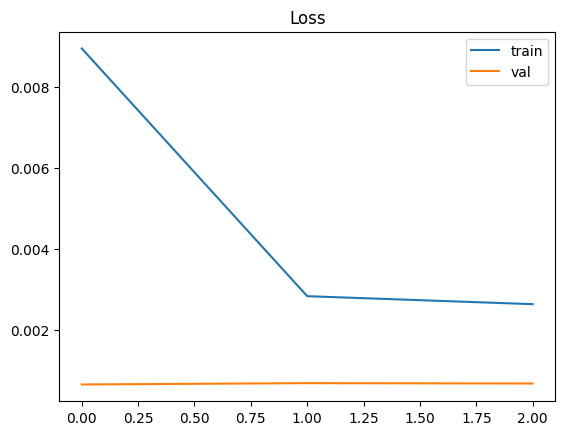

RMSE: 39.32737386699128
MAE: 35.72917275451965
R2 Score: -5.312319923534467
SMAPE: 55.87629754708334
Finished iteration offset=1197 days train_size=12 months test_size=28 days

Epoch 5: early stopping


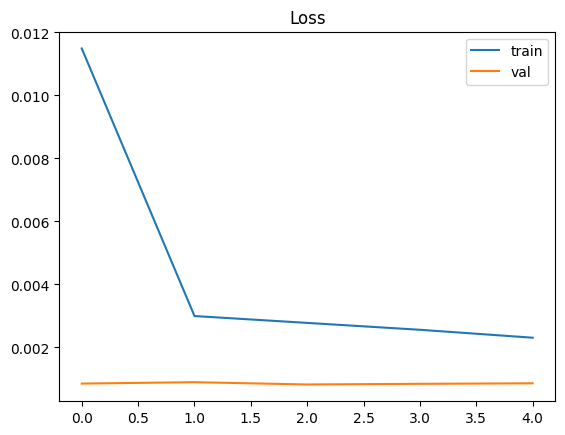

RMSE: 91.41916472934768
MAE: 88.44681505926184
R2 Score: -26.648610494075534
SMAPE: 94.31573197543096
Finished iteration offset=1204 days train_size=12 months test_size=28 days



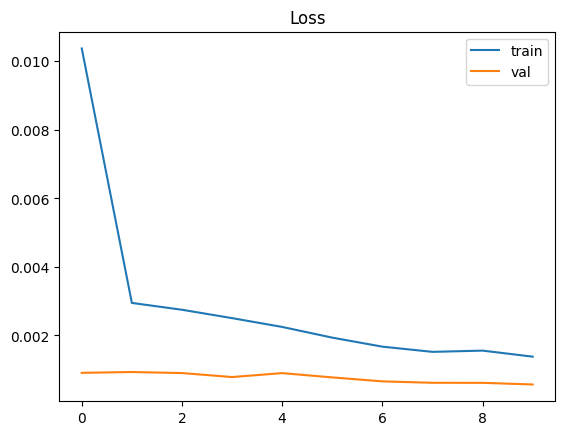

RMSE: 22.169961651275464
MAE: 18.07626671766679
R2 Score: -0.8399174083493859
SMAPE: 36.70080767200158
Finished iteration offset=1211 days train_size=12 months test_size=28 days



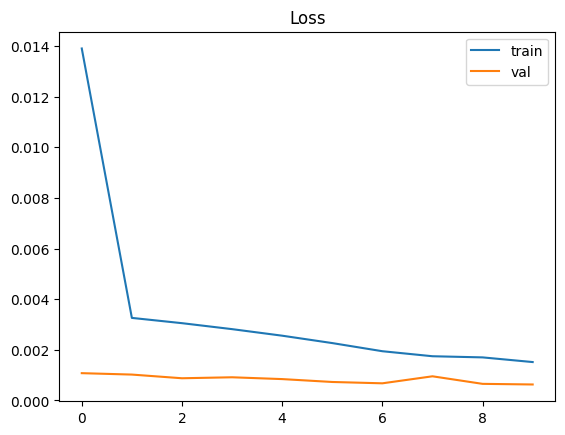

RMSE: 33.05226576788614
MAE: 23.728971395849648
R2 Score: -0.11730105585884565
SMAPE: 39.34226350291274
Finished iteration offset=1218 days train_size=12 months test_size=28 days

Epoch 9: early stopping


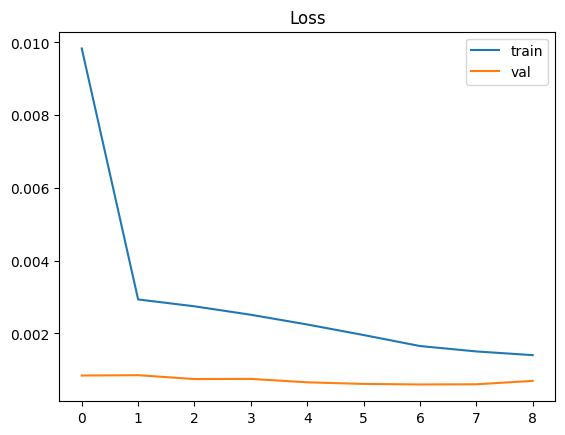

RMSE: 154.1013453222817
MAE: 147.19704066376067
R2 Score: -23.42254704586696
SMAPE: 100.61070467059699
Finished iteration offset=1225 days train_size=12 months test_size=28 days

Epoch 9: early stopping


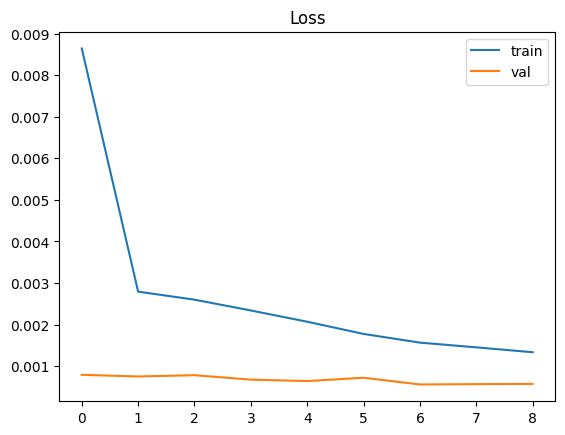

RMSE: 31.302634489796556
MAE: 25.99253878140446
R2 Score: 0.01418021485463139
SMAPE: 32.55670190389631
Finished iteration offset=1232 days train_size=12 months test_size=28 days

Epoch 6: early stopping


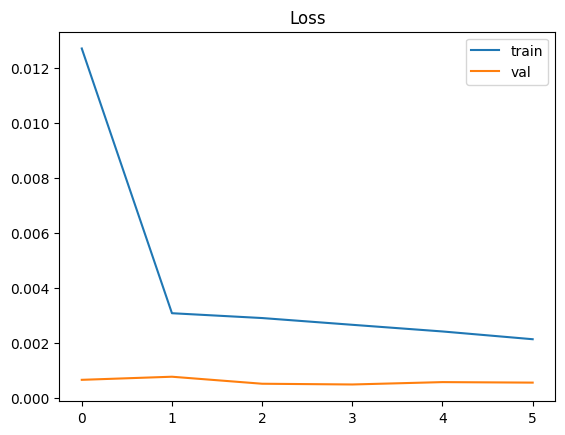

RMSE: 30.53460181509855
MAE: 25.749810755185695
R2 Score: -0.4967791891442348
SMAPE: 24.75289184431509
Finished iteration offset=1239 days train_size=12 months test_size=28 days

Epoch 3: early stopping


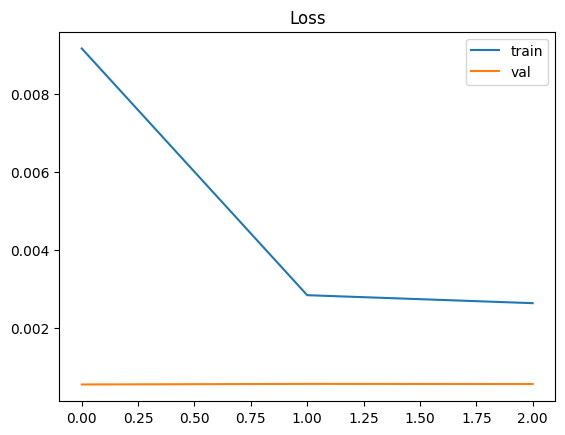

RMSE: 31.890944973305505
MAE: 24.497641372482004
R2 Score: -0.11136807591980813
SMAPE: 25.82487947524203
Finished iteration offset=1246 days train_size=12 months test_size=28 days

Epoch 9: early stopping


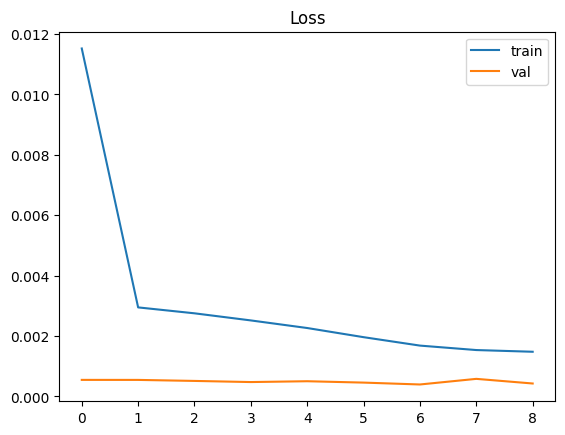

RMSE: 38.0295099874969
MAE: 31.60163818403637
R2 Score: 0.01615317956712825
SMAPE: 29.868808199926956
Finished iteration offset=1253 days train_size=12 months test_size=28 days



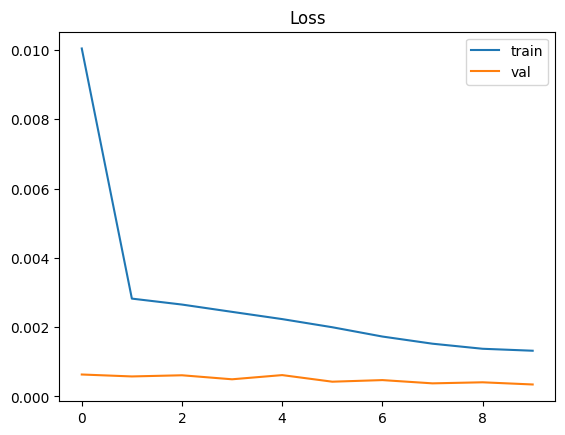

RMSE: 56.6851614714682
MAE: 45.337668767424844
R2 Score: -0.6294633780047636
SMAPE: 48.703154731529246
Finished iteration offset=1260 days train_size=12 months test_size=28 days



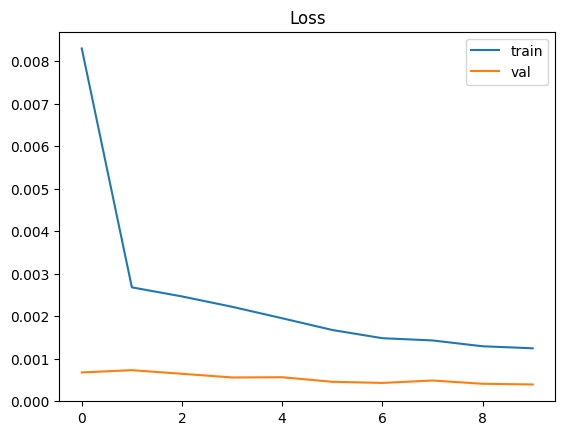

RMSE: 64.56426564176057
MAE: 53.60254904652208
R2 Score: -0.5468600796312297
SMAPE: 53.43437481724118
Finished iteration offset=1267 days train_size=12 months test_size=28 days

Epoch 7: early stopping


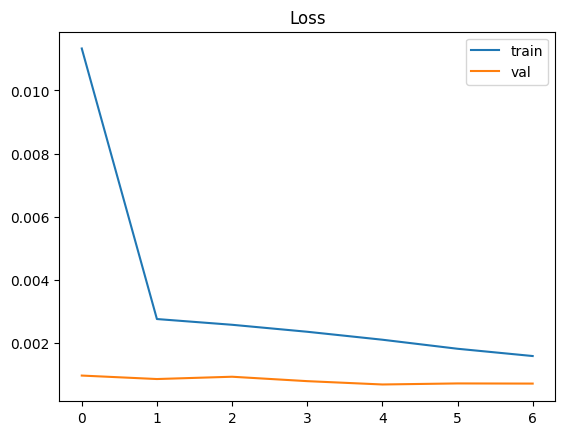

RMSE: 98.50631546227403
MAE: 84.2672320145712
R2 Score: -2.6808246453429514
SMAPE: 58.3122829347933
Finished iteration offset=1274 days train_size=12 months test_size=28 days



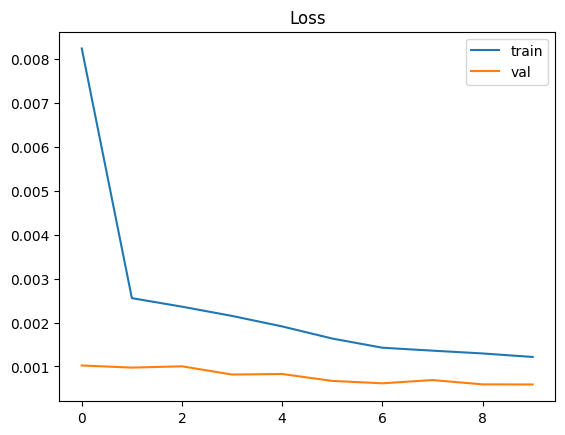

RMSE: 157.65085803789128
MAE: 142.53708085428255
R2 Score: -7.642151990698261
SMAPE: 80.19570192141803
Finished iteration offset=1281 days train_size=12 months test_size=28 days



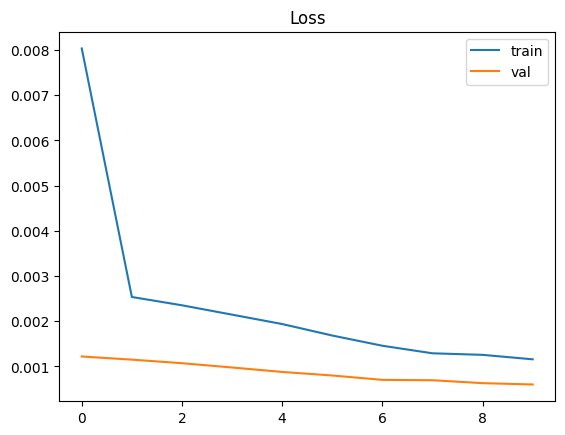

RMSE: 75.50763333757716
MAE: 65.03505116577516
R2 Score: -0.8978731807046683
SMAPE: 59.38925594526901
Finished iteration offset=1288 days train_size=12 months test_size=28 days



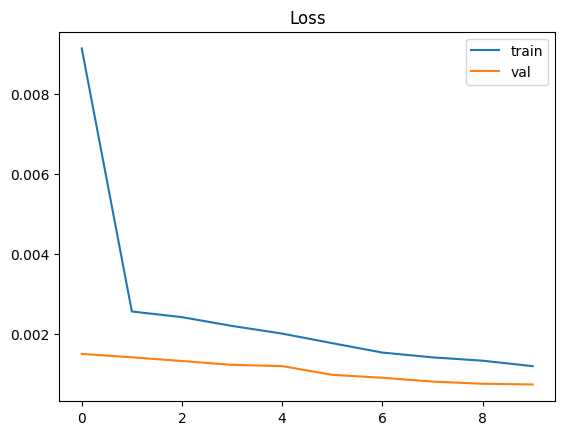

RMSE: 74.2187094467877
MAE: 60.64159992609854
R2 Score: -0.21422086116842864
SMAPE: 50.19009469679172
Finished iteration offset=1295 days train_size=12 months test_size=28 days



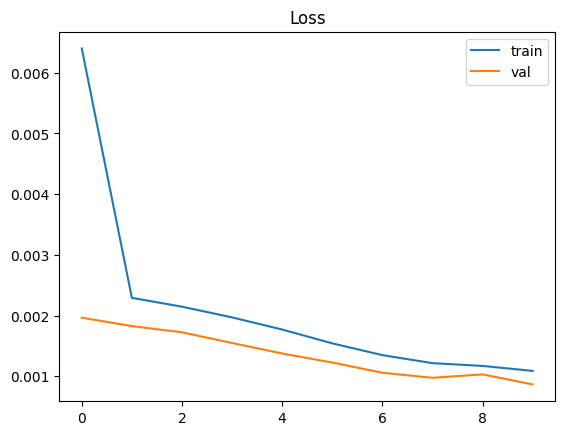

RMSE: 88.96576062434654
MAE: 75.30758749662077
R2 Score: -0.5531949662792508
SMAPE: 57.98078271932229
Finished iteration offset=1302 days train_size=12 months test_size=28 days



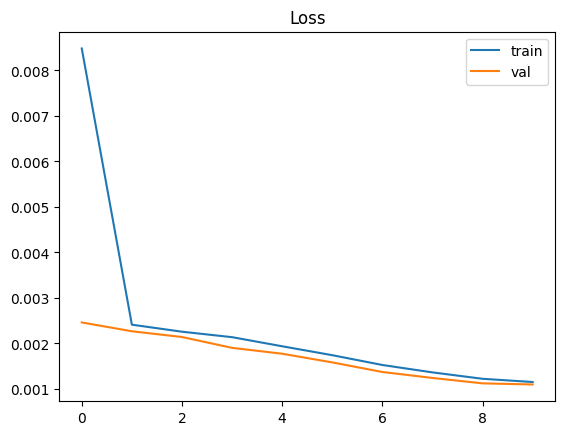

RMSE: 77.65989673815207
MAE: 60.85181823724093
R2 Score: -0.046855172146351265
SMAPE: 43.588514251118866
Finished iteration offset=1309 days train_size=12 months test_size=28 days



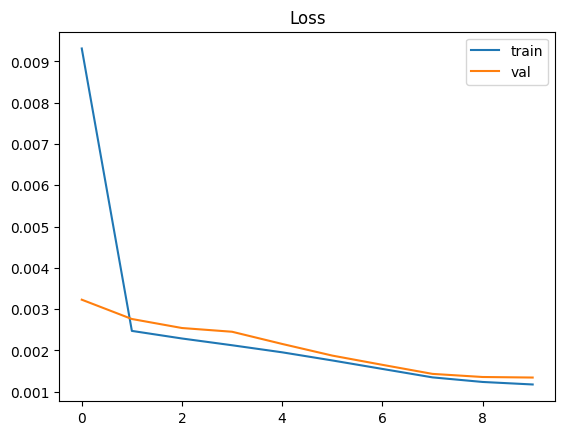

RMSE: 123.61263031655459
MAE: 106.20319306757713
R2 Score: -1.5773848052658912
SMAPE: 96.00378843673761
Finished iteration offset=1316 days train_size=12 months test_size=28 days



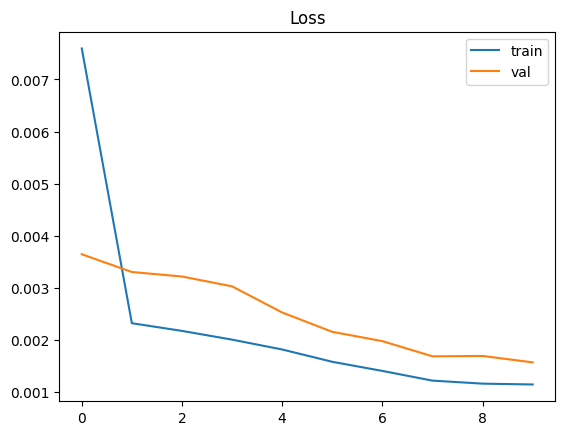

RMSE: 114.43211282700483
MAE: 95.25407270032417
R2 Score: -1.264846207961778
SMAPE: 89.21764917049232
Finished iteration offset=1323 days train_size=12 months test_size=28 days



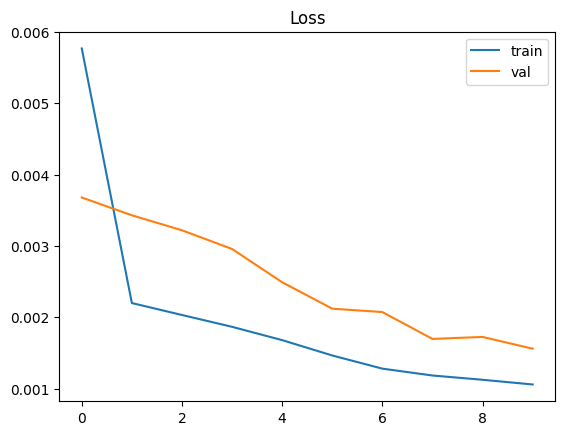

RMSE: 76.01378060099633
MAE: 61.519534985468816
R2 Score: -0.24135427511701035
SMAPE: 61.63082228371543
Finished iteration offset=1330 days train_size=12 months test_size=28 days



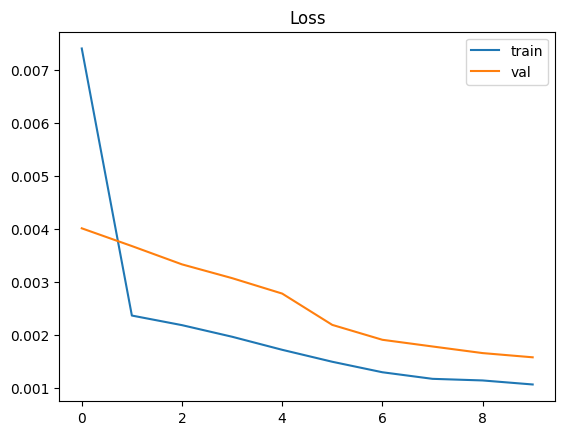

RMSE: 62.06168693354431
MAE: 49.64521579005713
R2 Score: -0.17713013526356747
SMAPE: 52.95810497823398
Finished iteration offset=1337 days train_size=12 months test_size=28 days



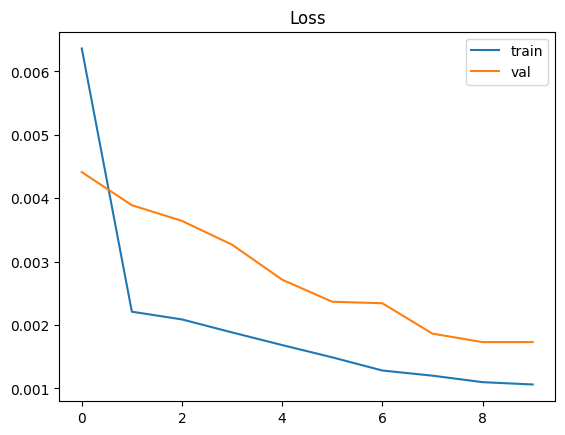

RMSE: 76.56896064368925
MAE: 59.620560063764614
R2 Score: -0.9192616152839781
SMAPE: 56.43209188795354
Finished iteration offset=1344 days train_size=12 months test_size=28 days



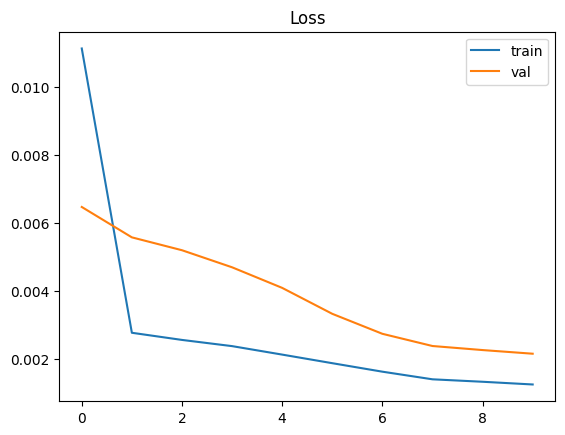

RMSE: 53.68344818401315
MAE: 45.08398474660408
R2 Score: -0.14857502903285957
SMAPE: 41.41723124862543
Finished iteration offset=1351 days train_size=12 months test_size=28 days



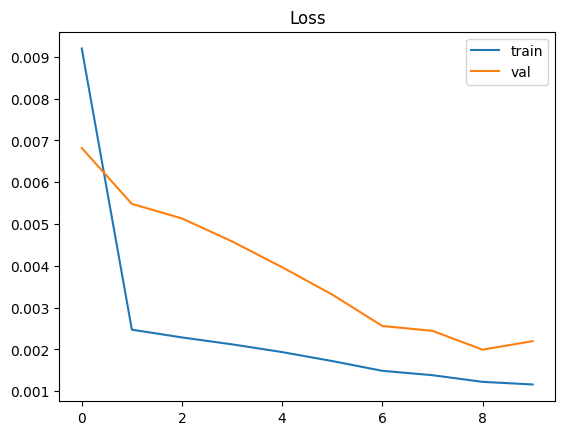

RMSE: 72.04728998566871
MAE: 56.34656511476246
R2 Score: -0.9685312020052235
SMAPE: 62.12089727662298
Finished iteration offset=1358 days train_size=12 months test_size=28 days



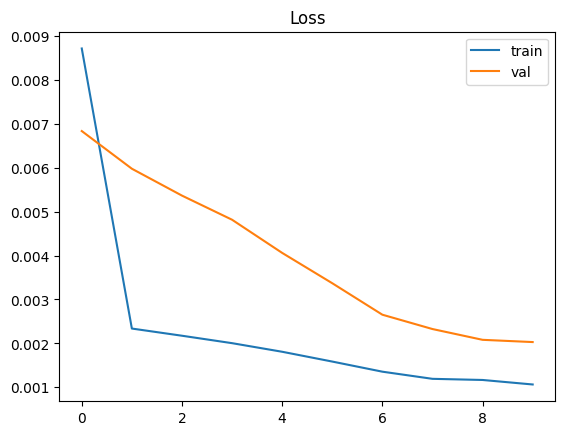

RMSE: 68.16055334205211
MAE: 56.093661982387395
R2 Score: -0.6557312046757133
SMAPE: 54.23878120662856
Finished iteration offset=1365 days train_size=12 months test_size=28 days



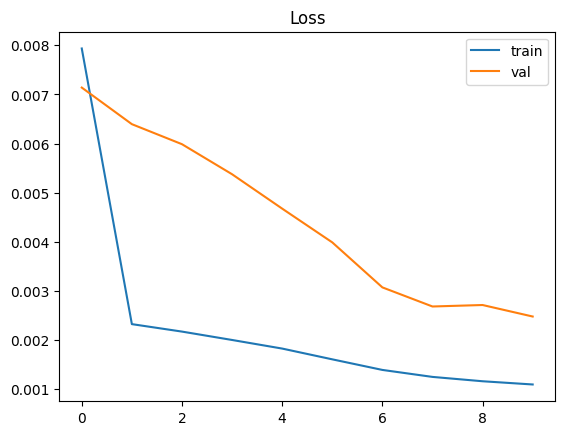

RMSE: 51.4456430183851
MAE: 43.378872616030996
R2 Score: -0.01710599699174331
SMAPE: 52.432913961448065
Finished iteration offset=1372 days train_size=12 months test_size=28 days



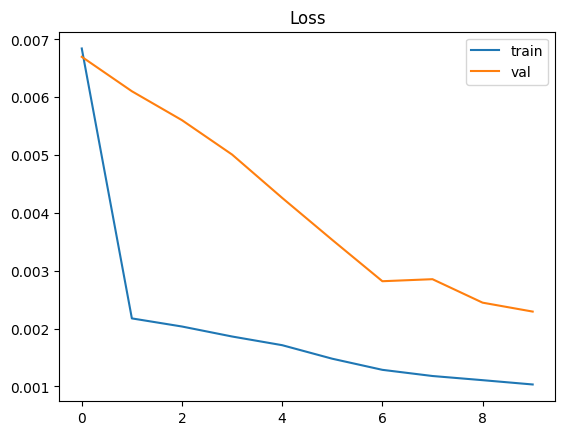

RMSE: 50.81418604006462
MAE: 39.00185683212754
R2 Score: -0.07513050893887363
SMAPE: 50.22725592433197
Finished iteration offset=1379 days train_size=12 months test_size=28 days



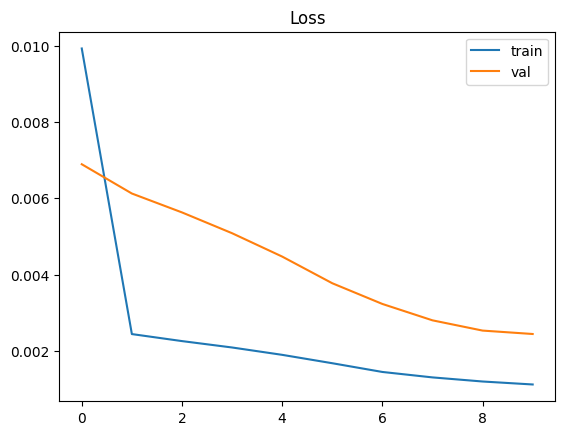

RMSE: 38.562661597046194
MAE: 30.55515723407524
R2 Score: 0.26616368578386806
SMAPE: 47.48284873151213
Finished iteration offset=1386 days train_size=12 months test_size=28 days



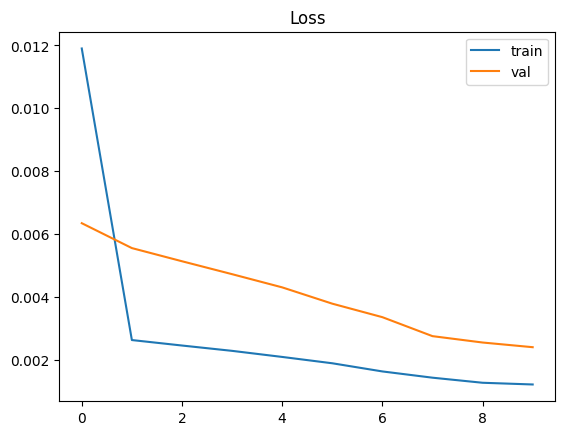

RMSE: 60.22165745945483
MAE: 54.51208614445526
R2 Score: -3.8365124787897473
SMAPE: 71.34828275568222
Finished iteration offset=1393 days train_size=12 months test_size=28 days



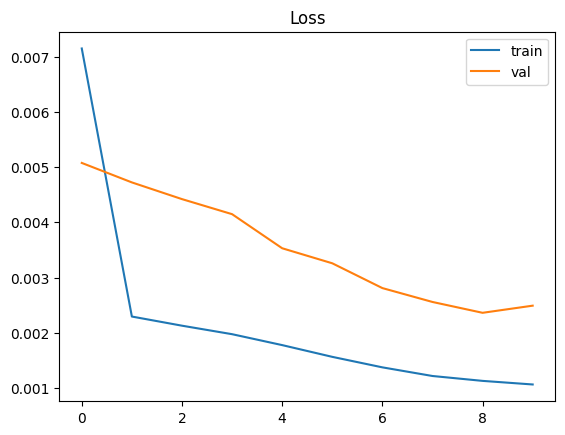

RMSE: 38.499070870617146
MAE: 30.88321608693827
R2 Score: -0.6873038234755466
SMAPE: 54.25476828547793
Finished iteration offset=1400 days train_size=12 months test_size=28 days



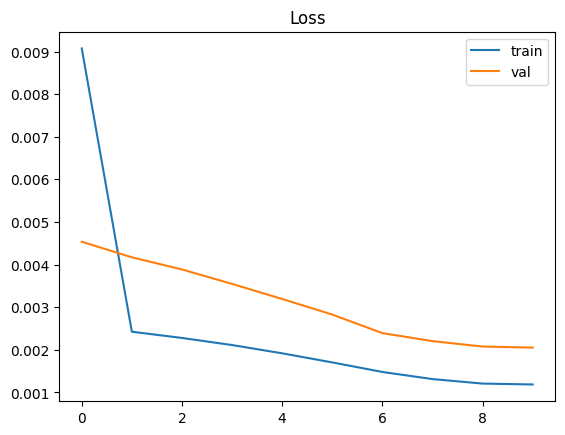

RMSE: 219.97697283551307
MAE: 211.86940345665775
R2 Score: -56.5278365852837
SMAPE: 129.49819613600278
Finished iteration offset=1407 days train_size=12 months test_size=28 days



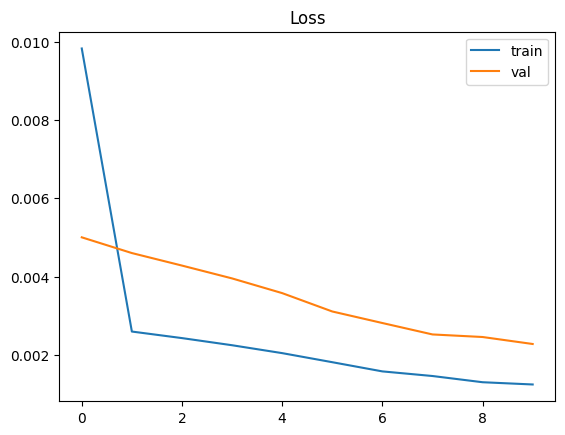

RMSE: 54.42077113748434
MAE: 49.40792245728874
R2 Score: -2.915096195578464
SMAPE: 66.1676388173879
Finished iteration offset=1414 days train_size=12 months test_size=28 days



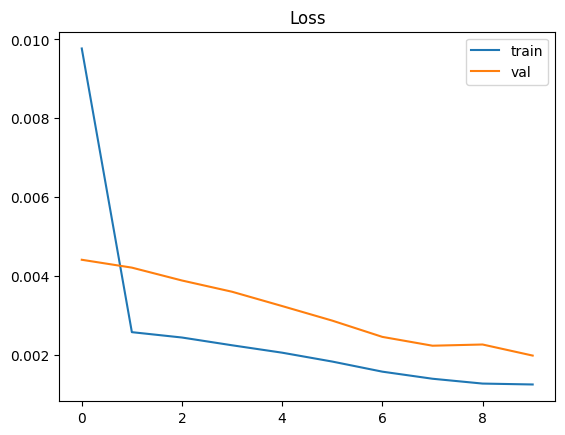

RMSE: 42.18333070579009
MAE: 36.753049374763606
R2 Score: -1.4125680539025178
SMAPE: 57.11399948353123
Finished iteration offset=1421 days train_size=12 months test_size=28 days



ValueError: not enough values to unpack (expected 6, got 5)

In [8]:
# Write experiment data to file
dir_name = 'Results'
file_name = 'LSTM_experiment_results.csv'
results_file_path = os.path.join(dir_name, file_name)

# Create the directory if it doesn't exist
os.makedirs(dir_name, exist_ok=True)

# Experiment parameters
tune_hyperparameters = False
epochs = 10

# train_size represents the number of months to be used for training (e.g. 4*12 is 4 years, 6 is 0.5 years)
# test_sizes represents the number of days to be used for testing (e.g. 4*7 is 4 weeks)
experiment_cases = [
    # {'input_dir': "Dataset", 'filename': "dataset_aqi_daily.csv", 'label': "AQI", 'train_size': 4*12, 'test_sizes': [4*7]},
    # {'input_dir': "Dataset", 'filename': "dataset_aqi_hourly.csv", 'label': "AQI", 'train_size': 4*12, 'test_sizes': [4*7]},
    # {'input_dir': "Dataset", 'filename': "dataset_aqi_daily_filled_with_neighbors.csv", 'label': "AQI", 'train_size': 4*12, 'test_sizes': [4*7]},
    # {'input_dir': "Dataset", 'filename': "dataset_aqi_hourly_filled_with_neighbors.csv", 'label': "AQI", 'train_size': 4*12, 'test_sizes': [4*7]},

    # {'input_dir': "Dataset", 'filename': "dataset_aqi_daily.csv", 'label': "AQI", 'train_size': 1*12, 'test_sizes': [4*7]},
    # {'input_dir': "Dataset", 'filename': "dataset_aqi_hourly.csv", 'label': "AQI", 'train_size': 1*12, 'test_sizes': [4*7]},
    # Amina
    {'input_dir': "Dataset", 'filename': "dataset_aqi_daily_filled_with_neighbors.csv", 'label': "AQI", 'train_size': 1*12, 'test_sizes': [4*7]},
    {'input_dir': "Dataset", 'filename': "dataset_aqi_hourly_filled_with_neighbors.csv", 'label': "AQI", 'train_size': 1*12, 'test_sizes': [4*7]},

    {'input_dir': "Dataset", 'filename': "dataset_aqi_daily.csv", 'label': "AQI", 'train_size': 0.5*12, 'test_sizes': [4*7]},
    # Emina
     {'input_dir': "Dataset", 'filename': "dataset_aqi_hourly.csv", 'label': "AQI", 'train_size': 0.5*12, 'test_sizes': [4*7]},
    {'input_dir': "Dataset", 'filename': "dataset_aqi_daily_filled_with_neighbors.csv", 'label': "AQI", 'train_size': 0.5*12, 'test_sizes': [4*7]},
    {'input_dir': "Dataset", 'filename': "dataset_aqi_hourly_filled_with_neighbors.csv", 'label': "AQI", 'train_size': 0.5*12, 'test_sizes': [4*7]}
]

for experiment_case in experiment_cases:
    input_dir = experiment_case['input_dir']
    #input_dir = "/content/gdrive/MyDrive/AirQuality/AQI prediction code/AQI_PM2.5/Dataset"
    filename = experiment_case['filename']
    label = experiment_case['label']
    train_size = experiment_case['train_size']
    test_sizes = experiment_case['test_sizes']

    if 'hourly' in filename:
        look_back = 5
        batch_size = 128
    if 'daily' in filename:
        look_back = 3
        batch_size = 30

    # Load the CSV file
    df = pd.read_csv(os.path.join(input_dir,filename))
    df.DateTime = pd.to_datetime(df.DateTime)
    df = df.set_index('DateTime')

    print(f'\nRunning experiment for {filename} with label {label}:\n')
    for test_size in test_sizes:
        offset = 0 # start from the beginning of the dataframe
        while True:
            train_data, test_data, scaler, start_date, slice_date, end_date = split_data(df, offset, train_size, test_size)

            if train_data is None or test_data is None:
                print(f'No more data for test size {test_size} days')
                break

            offset += 7 # move train+test window forward by 7 days for next iteration

            # if start_date == pd.to_datetime('2021-03-30 17:00:00'):
            #     print(f'Offset = {offset}')
            #     break

            model, history = train_LSTM_model(train_data, look_back, batch_size, epochs, tune_hyperparameters)

            rmse, mae, r2, smape, testPredict, y_test = test_LSTM_model(model, train_data, test_data, look_back, scaler)

            # Prepare data for CSV
            data = {
                'DateTime of experiment': [datetime.datetime.now()],
                'Dataset used': [filename],
                'Label predicted': [label],
                'Training data from': [start_date],
                'Training data to': [slice_date],
                'Testing data from': [slice_date],
                'Testing data to': [end_date],
                'Test size': [len(test_data)],
                'look_back': [look_back],
                'batch_size': [batch_size],
                'epochs': [epochs],
                # 'Model configuration': [json.dumps(model.get_config())],
                'Test Predictions': [testPredict.tolist()],
                'Test Data': [y_test.tolist()],
                'RMSE': [rmse],
                'MAE': [mae],
                'R2': [r2],
                'SMAPE': [smape]
            }

            # print finished iteration
            print(f'Finished iteration offset={offset} days train_size={train_size} months test_size={test_size} days\n')

            # Convert to DataFrame
            df_result = pd.DataFrame(data)

            # Write DataFrame to CSV
            df_result.to_csv(results_file_path, mode='a', header=not os.path.exists(results_file_path), index=False)


Results for dataset_aqi_hourly.csv with label AQI, train_size=12 months, test_size=28 days:

Errors for 1 days:
MAE: 36.31899636334692
RMSE: 50.365732799304446
R2: 0.3706397573931367
SMAPE: 45.21477758262632
Errors for 7 days:
MAE: 73.60401959129985
RMSE: 106.22985438900528
R2: -1.9341325796764046
SMAPE: 69.09245279714203
Errors for 14 days:
MAE: 84.4759027071085
RMSE: 138.9997460605382
R2: -4.029978753769988
SMAPE: 66.04233933107697
Errors for 28 days:
MAE: 96.33956457508351
RMSE: 164.2943154123945
R2: -6.465744375260686
SMAPE: 73.22179697175024


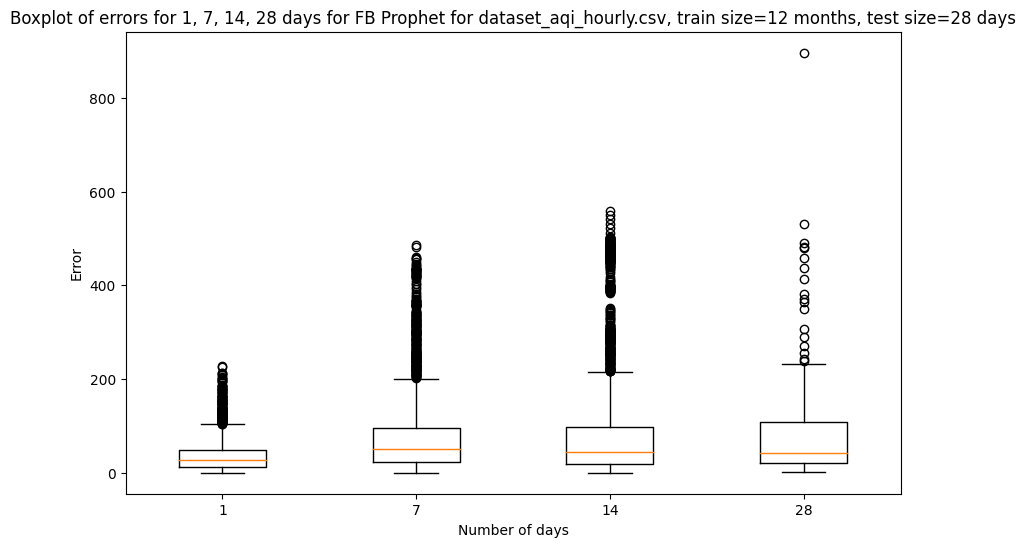

In [ ]:
df_results = pd.read_csv(results_file_path)

# convert to datetime
df_results['DateTime of experiment'] = pd.to_datetime(df_results['DateTime of experiment'])
df_results['Training data from'] = pd.to_datetime(df_results['Training data from'])
df_results['Training data to'] = pd.to_datetime(df_results['Training data to'])
df_results['Testing data from'] = pd.to_datetime(df_results['Testing data from'])
df_results['Testing data to'] = pd.to_datetime(df_results['Testing data to'])
# convert Test Data and Test Predictions to lists of doubles
df_results['Test Data'] = df_results['Test Data'].apply(lambda x: [item[0] for item in json.loads(x)])
df_results['Test Predictions'] = df_results['Test Predictions'].apply(lambda x: [item[0] for item in json.loads(x)])
# calculate time delta in months round to 0 decimals
df_results['Training Duration'] = ((df_results['Training data to'] - df_results['Training data from']) / np.timedelta64(1, 'M')).round(0).astype(int)
df_results['Testing duration'] = ((df_results['Testing data to'] - df_results['Testing data from']) / np.timedelta64(1, 'D')).round(0).astype(int)

for experiment_case in experiment_cases:
    filename = experiment_case['filename']
    label = experiment_case['label']
    train_size = experiment_case['train_size']
    test_sizes = experiment_case['test_sizes']

    print(f'\nResults for {filename} with label {label}, train_size={train_size} months, test_size={test_sizes[0]} days:\n')

    df_results_filtered = df_results[(df_results['Dataset used'] == filename) & (df_results['Label predicted'] == label) & (df_results['Training Duration'] == train_size) & (df_results['Testing duration'] == test_sizes[0])]

    # Columns that contain list of predictions for each experiment
    tests_column = df_results_filtered['Test Data']
    predictions_column = df_results_filtered['Test Predictions']

    test_data_for_periods = []
    prediction_data_for_periods = []

    # Calculating errors for 1, 7, 14, 28 days and plotting forecast plot and boxplot
    for i in [1, 7, 14, 28]:
        # take i-1-th (-1 because enumerations starts from 0) element from each list of tests and predictions columns
        if 'daily' in filename:
            tests = tests_column.apply(lambda x: x[i-1])
            predictions = predictions_column.apply(lambda x: x[i-1])
        elif 'hourly' in filename:
            tests = pd.Series([item for sublist in tests_column.apply(lambda x: x[(i-1)*24:i*24]) for item in sublist])
            predictions = pd.Series([item for sublist in predictions_column.apply(lambda x: x[(i-1)*24:i*24]) for item in sublist])

        test_data_for_periods.append(tests)
        prediction_data_for_periods.append(predictions)

        # Calculate errors
        mae = mean_absolute_error(tests, predictions)
        rmse = np.sqrt(mean_squared_error(tests, predictions))
        r2 = r2_score(tests, predictions)
        smape = calculate_smape(tests, predictions)

        print(f'Errors for {i} days:')
        print(f'MAE: {mae}')
        print(f'RMSE: {rmse}')
        print(f'R2: {r2}')
        print(f'SMAPE: {smape}')

    # Plot boxplot of errors as error = abs(predictions - tests) for 1, 7, 14, 28 days on one plot where x label shows number of days
    plt.figure(figsize=(10,6))
    plt.boxplot([abs(test_data_for_periods[0] - prediction_data_for_periods[0]), abs(test_data_for_periods[1] - prediction_data_for_periods[1]), abs(test_data_for_periods[2] - prediction_data_for_periods[2]), abs(test_data_for_periods[3] - prediction_data_for_periods[3])])
    plt.xticks([1, 2, 3, 4], [1, 7, 14, 28])
    plt.xlabel('Number of days')
    plt.ylabel('Error')
    plt.title(f'Boxplot of errors for 1, 7, 14, 28 days for FB Prophet for {filename}, train size={train_size} months, test size={test_sizes[0]} days')
    plt.show()